# Exploration of Nutrition and Costs


data sources:

- https://fdc.nal.usda.gov/download-datasets.html
- https://www.ers.usda.gov/data-products/fruit-and-vegetable-prices.aspx
- https://www.kaggle.com/datasets/trolukovich/nutritional-values-for-common-foods-and-products
- https://www.fda.gov/food/nutrition-facts-label/daily-value-nutrition-and-supplement-facts-labels

-https://marketnews.usda.gov/mnp/FVDataDownload

explored, but discarded:
- https://www.kaggle.com/datasets/thedevastator/the-nutritional-content-of-food-a-comprehensive
- https://www.kaggle.com/datasets/thunderz/food-data


inspiration sources:

- https://nutritionj.biomedcentral.com/articles/10.1186/s12937-019-0496-5
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2954450/
- https://www.healthline.com/nutrition/29-cheap-healthy-foods
- https://nutritionfacts.org/blog/best-nutrition-bang-for-your-buck/

## Idea/Work Backlog

- before fuzzy matching, create subsets based on matching storage_state and Form (i.e. "Canned" and "Canned", 'Dried'=='Dried')
- least/most costly calories per gram (`dollars per calorie per gram`)
    - silimar for other nutrients


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Nutrition and Assess 

In [3]:
# data source:
# https://www.kaggle.com/datasets/trolukovich/nutritional-values-for-common-foods-and-products

nutrition = pd.read_csv('data/nutrition.csv', index_col='Unnamed: 0')

In [4]:
nutrition.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8789 entries, 0 to 8788
Data columns (total 76 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   name                         8789 non-null   object
 1   serving_size                 8789 non-null   object
 2   calories                     8789 non-null   int64 
 3   total_fat                    8789 non-null   object
 4   saturated_fat                7199 non-null   object
 5   cholesterol                  8789 non-null   object
 6   sodium                       8789 non-null   object
 7   choline                      8789 non-null   object
 8   folate                       8789 non-null   object
 9   folic_acid                   8789 non-null   object
 10  niacin                       8789 non-null   object
 11  pantothenic_acid             8789 non-null   object
 12  riboflavin                   8789 non-null   object
 13  thiamin                      8789

In [5]:
nutrition.head()

,name,serving_size,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,...,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
0,Cornstarch,100 g,381,0.1g,NaN,0,9.00 mg,0.4 mg,0.00 mcg,0.00 mcg,...,0.05 g,0.009 g,0.016 g,0.025 g,0.00 mg,0.0 g,0.09 g,0.00 mg,0.00 mg,8.32 g
1,"Nuts, pecans",100 g,691,72g,6.2g,0,0.00 mg,40.5 mg,22.00 mcg,0.00 mcg,...,71.97 g,6.180 g,40.801 g,21.614 g,0.00 mg,0.0 g,1.49 g,0.00 mg,0.00 mg,3.52 g
2,"Eggplant, raw",100 g,25,0.2g,NaN,0,2.00 mg,6.9 mg,22.00 mcg,0.00 mcg,...,0.18 g,0.034 g,0.016 g,0.076 g,0.00 mg,0.0 g,0.66 g,0.00 mg,0.00 mg,92.30 g
3,"Teff, uncooked",100 g,367,2.4g,0.4g,0,12.00 mg,13.1 mg,0,0,...,2.38 g,0.449 g,0.589 g,1.071 g,0,0,2.37 g,0,0,8.82 g
4,"Sherbet, orange",100 g,144,2g,1.2g,1mg,46.00 mg,7.7 mg,4.00 mcg,0.00 mcg,...,2.00 g,1.160 g,0.530 g,0.080 g,1.00 mg,0.0 g,0.40 g,0.00 mg,0.00 mg,66.10 g


In [61]:
nutrition[nutrition.name=='Wheat flour, whole-grain'].T

,683
name,"Wheat flour, whole-grain"
serving_size,100 g
calories,340
total_fat,2.5g
saturated_fat,0.4g
...,...
name_split,"[Wheat, flour, whole-grain]"
food_types,
storage_state,
grade,


In [7]:
# will use this food dataset since all are 100g serving sizes
# but will need to parse the nutrients from string to numbers and units of measure

# Categorize based on most frequent words

In [8]:
# split the name into lists in orders to find the most frequently used words

nutrition['name_split'] = nutrition['name'].apply(lambda x: x.replace(",", "").split())

words = pd.Series([word for EachElement in nutrition['name_split'] for word in EachElement])
words.value_counts()

and          2092
fat          1994
cooked       1785
lean         1508
separable    1457
             ... 
VITAMAN         1
FRUITY          1
beaked          1
Hazelnuts       1
degree          1
Length: 4514, dtype: int64

In [63]:
words.value_counts().quantile(q=[0,0.25, 0.50, 0.75, 0.99, 0.999, 0.9999, 1])

0.0000       1.0000
0.2500       1.0000
0.5000       2.0000
0.7500       7.0000
0.9900     242.4800
0.9990    1422.6290
0.9999    2047.7726
1.0000    2092.0000
dtype: float64

In [10]:
# top 83 words (of distinct 4514!) is top 50 percent of word counts

(words.value_counts().cumsum()/words.value_counts().sum()).iloc[83]

0.49999273414226547

In [11]:
# look up each top word, then look up `name` with that word, analyze, identify groupings


theWord = words.value_counts().index[130]
theWord

# words of interest that can lead to categorizing:

# FOODS
# Babyfood: 'Babyfood'
# Beef: 'Beef'
# Chicken: 'Chicken'
# Pork: 'Pork'
# Lamb: 'Lamb'
# Fish: 'Fish'
# Cheese: 'Cheese'
# Crackers: 'Crackers'
# Soup: 'Soup'
# Cereals: 'Cereals'

# STORAGE STATE
# Fresh: ['fresh', 'raw']
# Frozen: ['frozen', 'raw or frozen']
# Canned: 'canned'
# Dried: 'dry'

# PREPARED
# cooked: 'cooked'
# roasted: 'roasted'
# boiled: 'boiled'
# drained: 'drained'    ## typically with 'boiled'
# solids: ['drained solids', 'solids and liquids']
# prepared: 'prepared'
# uprepared: 'unprepared'
# salt: [without salt, with salt, no salt added]  ## sodium?

# ATTRIBUTES
# boneless: 'boneless'
# fat: ['low fat', 'fat free', 'reducted fat', ...]
# skin: ['skin', 'with skin, without skin', 'meat and skin', 'cooked without skin']

# GRADE
# all: ['all varieties', 'all types', 'all grades']
# choice: 'choice' #like preferred or premium?
# select: 'select' # similar to choice
# imported: imported
# ready-to-eat:ready-to-eat

##################
# explore later
# lean: 'separable lean only', X% fat Y% lean 
# meat:
# water:

'sodium'

In [12]:
# lookup records where `name` contains the word

nutrition[nutrition['name_split'].apply(lambda x: theWord in x)].name.iloc[:50]

282                                    Catsup, low sodium
734                         Beef, reduced sodium, bologna
739                         Peanut butter, reduced sodium
797                          Crackers, low sodium, cheese
813                          Cheese, low sodium, parmesan
1060                            Cheese, low sodium, swiss
1070                            Bacon, low sodium, turkey
1242                              Milk, fluid, low sodium
1261                              Frankfurter, low sodium
1557                    Crackers, low sodium, toast thins
1789                      Salami, less sodium, beef, pork
1992                       Cheese, low sodium, mozzarella
2122              Soup, lower sodium, beef broth, SWANSON
2123              Pickles, reduced sodium, dill, cucumber
2173              Soup, canned, low sodium, chicken broth
2255               Tomato and vegetable juice, low sodium
2283               Popcorn, low fat and sodium, microwave
2494          

In [64]:
# value count of prhases found by regex

(nutrition[nutrition['name_split']
           .apply(lambda x: 'sodium' in x)]
           .name
           .str.extract(r",([^,]*sodium[^,\n]*)[,\n]")
           .value_counts()
)

 low sodium                                        31
 reduced sodium                                    20
 with sodium saccharin                              2
 less/reduced sodium                                2
 sodium                                             2
  lower sodium                                      1
 reduced/low sodium                                 1
 without added sodium                               1
 with lauric acid oil and sodium caseinate          1
 with added potassium and sodium                    1
 very low sodium                                    1
 sweetened with sodium saccharin                    1
 sodium aluminum sulfate                            1
 no sodium added                                    1
 25% less sodium                                    1
 no added sodium                                    1
 lower sodium                                       1
 low sodium no salt                                 1
 low sodium (includes bread 

In [14]:
(nutrition[nutrition['name_split']
           .apply(lambda x: 'salt' in x)]
           .name
           .str.extract(r",([^,]*salt[^,\n]*)[,\n]")
           .value_counts()
)

 without salt                              245
 with salt                                 239
 no salt added                              28
 with salt added                            25
 without salt added                         17
 salt added in processing                   12
 salt not added in processing                5
 without added salt                          5
 with added salt                             4
 low salt                                    3
 no salt                                     3
 salt added                                  3
 salt                                        2
 boiled with salt                            1
 without salt (includes USDA commodity)      1
 with salt added (decorticated)              1
 salt pork                                   1
 with no added salt                          1
 sodium-citrate and salt                     1
 skin with salt                              1
 cooked without salt                         1
 low sodium n

***
Based on the groupings study and the development of some dictionaries, functions are also built to execute the categorization of these food items.
***

In [15]:
import re

In [16]:
def categorize(TheSeries: pd.Series, pattern: list, category: str, regex=False):
    if type(pattern) == list:
        for eachItem in pattern:
            if regex:
                pat = fr',([^,]*{eachItem}[^,\n]*)[,\n]'
                return nutrition.name.apply(lambda x: category if re.search(pat,x) else '')
            else:
                return TheSeries.apply(lambda x: category if eachItem in x else '')
    elif type(pattern) == str:
        if regex:
            pat = fr',([^,]*{pattern}[^,\n]*)[,\n]'
            return nutrition.name.apply(lambda x: category if re.search(pat,x) else '')
        else:
            return TheSeries.apply(lambda x: category if pattern in x else '')
    else:
        print("'pattern' parameter dtype is expected to be either str or list")

In [17]:
def bulk_categorize(theSeries: pd.Series, theDict: dict, column_name, regex=False):
    temp_df = pd.DataFrame()
    for key in theDict:
        tempSeries = categorize(theSeries, theDict[key], key, regex)
        temp_df[key] = tempSeries
    temp_df[column_name] = temp_df.apply(lambda row: ''.join(str(val) for val in row), axis=1)
    temp_df = temp_df[[column_name]]
    return temp_df

In [18]:
food_types_dict = {
    'Babyfood': 'Babyfood',
    'Beef': 'Beef',
    'Chicken': 'Chicken',
    'Pork': 'Pork',
    'Lamb': 'Lamb',
    'Fish': 'Fish',
    'Cheese': 'Cheese',
    'Crackers': 'Crackers',
    'Soup': 'Soup',
    'Cereals': 'Cereals'
}

storage_state_dict = {
    'Fresh': ['fresh', 'raw'],
    'Frozen': ['frozen', 'raw or frozen'],
    'Canned': 'canned',
    'Dried': 'dry'
}

grade_dict = {
    'all': ['all varieties', 'all types', 'all grades'],
    'choice': 'choice',
    'select': 'select',
    'imported': 'imported',
    'ready_to_eat':'ready-to-eat'
}

salt_dict = {
    'No Salt':['without salt', 'without added sodium', 'no sodium', 
               'no added sodium', 'no salt added', 'without added salt',
               'no salt', 'no added salt', 'without salt added'],
    'Low Salt':['low sodium', 'reduced sodium', 'lower sodium', 'less sodium', 'low salt'],
    'Salt':['with sodium', 'with salt', 'salt added', 'salt']    
}

In [19]:
s = bulk_categorize(nutrition.name, food_types_dict, 'food_types')
t = bulk_categorize(nutrition.name, storage_state_dict, 'storage_state')
u = bulk_categorize(nutrition.name, grade_dict, 'grade')
v = bulk_categorize(nutrition.name, salt_dict, 'Salt', regex=True)
nutrition = pd.concat([nutrition, s, t, u, v],axis=1)
nutrition

,name,serving_size,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,...,alcohol,ash,caffeine,theobromine,water,name_split,food_types,storage_state,grade,Salt
0,Cornstarch,100 g,381,0.1g,NaN,0,9.00 mg,0.4 mg,0.00 mcg,0.00 mcg,...,0.0 g,0.09 g,0.00 mg,0.00 mg,8.32 g,[Cornstarch],,,,
1,"Nuts, pecans",100 g,691,72g,6.2g,0,0.00 mg,40.5 mg,22.00 mcg,0.00 mcg,...,0.0 g,1.49 g,0.00 mg,0.00 mg,3.52 g,"[Nuts, pecans]",,,,
2,"Eggplant, raw",100 g,25,0.2g,NaN,0,2.00 mg,6.9 mg,22.00 mcg,0.00 mcg,...,0.0 g,0.66 g,0.00 mg,0.00 mg,92.30 g,"[Eggplant, raw]",,,,
3,"Teff, uncooked",100 g,367,2.4g,0.4g,0,12.00 mg,13.1 mg,0,0,...,0,2.37 g,0,0,8.82 g,"[Teff, uncooked]",,,,
4,"Sherbet, orange",100 g,144,2g,1.2g,1mg,46.00 mg,7.7 mg,4.00 mcg,0.00 mcg,...,0.0 g,0.40 g,0.00 mg,0.00 mg,66.10 g,"[Sherbet, orange]",,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8784,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",100 g,125,3.5g,1.4g,62mg,54.00 mg,64.5 mg,4.00 mcg,0.00 mcg,...,0.0 g,1.11 g,0.00 mg,0.00 mg,72.51 g,"[Beef, raw, all, grades, trimmed, to, 0"", fat,...",Beef,,,
8785,"Lamb, cooked, separable lean only, composite o...",100 g,206,8.9g,3.9g,109mg,50.00 mg,0,0.00 mcg,0.00 mcg,...,0,1.60 g,0,0,59.95 g,"[Lamb, cooked, separable, lean, only, composit...",Lamb,Frozen,imported,
8786,"Lamb, raw, separable lean and fat, composite o...",100 g,277,23g,12g,78mg,39.00 mg,0,1.00 mcg,0.00 mcg,...,0,0.92 g,0,0,59.80 g,"[Lamb, raw, separable, lean, and, fat, composi...",Lamb,Frozen,imported,
8787,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",100 g,121,3g,1.1g,60mg,53.00 mg,64.2 mg,4.00 mcg,0.00 mcg,...,0.0 g,1.10 g,0.00 mg,0.00 mg,73.43 g,"[Beef, raw, all, grades, trimmed, to, 0"", fat,...",Beef,,,


# EDA on Categories

In [65]:
# still a lot of records without a `food type`

nutrition.food_types.value_counts()

                     5446
Beef                  972
Cereals               352
Pork                  344
Chicken               302
Lamb                  300
Babyfood              243
Fish                  239
Soup                  235
Cheese                153
Crackers              120
ChickenSoup            45
BeefSoup               16
CheeseCrackers         12
CheeseSoup              6
CheeseCereals           2
CrackersSoup            1
ChickenCheeseSoup       1
Name: food_types, dtype: int64

In [21]:
nutrition[nutrition.food_types=='CheeseCereals'].name.iloc[0]

"Cereals, dry, Ham 'n' Cheese flavor, Instant Grits, QUAKER"

In [22]:
nutrition[nutrition.food_types=='CrackersSoup'].name.iloc[0]

'SUNSHINE, Soup & Oyster Crackers (large), KRISPY'

In [23]:
nutrition[nutrition.food_types=='ChickenCheeseSoup'].name.iloc[0]

"CAMPBELL'S CHUNKY Soups, Chicken Broccoli Cheese & Potato Soup"

In [24]:
nutrition.groupby('food_types').agg({'calories':'mean'}).sort_values('calories', ascending=False)

,calories
food_types,
CheeseCrackers,487.833333
Crackers,455.966667
CrackersSoup,416.000000
CheeseCereals,357.500000
Cereals,341.744318
Cheese,279.490196
,232.385053
Lamb,230.956667
Pork,214.729651


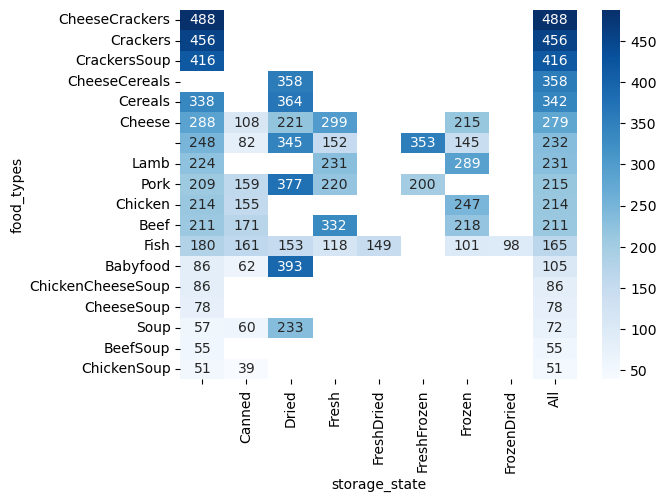

In [25]:
sns.heatmap(nutrition.pivot_table(index='food_types', values='calories', columns='storage_state', aggfunc='mean', margins=True)
            .drop('All')
            .sort_values('All',ascending=False)
            , annot=True, fmt='.0f', cmap='Blues'
           );

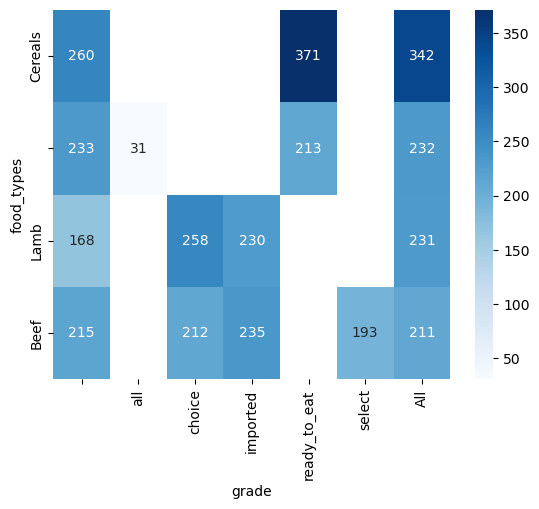

In [66]:
sns.heatmap(nutrition.pivot_table(index='food_types', values='calories', columns='grade', aggfunc='mean', margins=True)
            .drop('All')
            .dropna(how='all',subset=['all','choice','imported','ready_to_eat','select'])
            .sort_values('All',ascending=False)
            , annot=True, fmt='.0f', cmap='Blues'
           );

# transform Nutrition from wide to long

In [27]:
# transform from wide to long

food = nutrition.drop('name_split', axis=1).melt(id_vars=['name','food_types','storage_state','grade', 'Salt'])
food['value'] = food['value'].values.astype(str)
food.head()



,name,food_types,storage_state,grade,Salt,variable,value
0,Cornstarch,,,,,serving_size,100 g
1,"Nuts, pecans",,,,,serving_size,100 g
2,"Eggplant, raw",,,,,serving_size,100 g
3,"Teff, uncooked",,,,,serving_size,100 g
4,"Sherbet, orange",,,,,serving_size,100 g


In [28]:
pattern = r'(\d+(?:\.\d+)?)\s?(\D+)?'
food[['amount','unit of measure']] = food['value'].str.extract(pattern)
food['amount'] = pd.to_numeric(food['amount'],errors='coerce')

In [29]:
food[food['name']=='Wheat flour, whole-grain'].head(60)

,name,food_types,storage_state,grade,Salt,variable,value,amount,unit of measure
683,"Wheat flour, whole-grain",,,,,serving_size,100 g,100.000,g
9472,"Wheat flour, whole-grain",,,,,calories,340,340.000,NaN
18261,"Wheat flour, whole-grain",,,,,total_fat,2.5g,2.500,g
27050,"Wheat flour, whole-grain",,,,,saturated_fat,0.4g,0.400,g
35839,"Wheat flour, whole-grain",,,,,cholesterol,0,0.000,NaN
44628,"Wheat flour, whole-grain",,,,,sodium,2.00 mg,2.000,mg
53417,"Wheat flour, whole-grain",,,,,choline,31.2 mg,31.200,mg
62206,"Wheat flour, whole-grain",,,,,folate,44.00 mcg,44.000,mcg
70995,"Wheat flour, whole-grain",,,,,folic_acid,0.00 mcg,0.000,mcg
79784,"Wheat flour, whole-grain",,,,,niacin,4.957 mg,4.957,mg


In [30]:
food = food.drop(labels=['value'], axis=1)
food

,name,food_types,storage_state,grade,Salt,variable,amount,unit of measure
0,Cornstarch,,,,,serving_size,100.00,g
1,"Nuts, pecans",,,,,serving_size,100.00,g
2,"Eggplant, raw",,,,,serving_size,100.00,g
3,"Teff, uncooked",,,,,serving_size,100.00,g
4,"Sherbet, orange",,,,,serving_size,100.00,g
...,...,...,...,...,...,...,...,...
659170,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",Beef,,,,water,72.51,g
659171,"Lamb, cooked, separable lean only, composite o...",Lamb,Frozen,imported,,water,59.95,g
659172,"Lamb, raw, separable lean and fat, composite o...",Lamb,Frozen,imported,,water,59.80,g
659173,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",Beef,,,,water,73.43,g


# Load Price Data

In [70]:
fruit = pd.read_csv('https://www.ers.usda.gov/webdocs/DataFiles/51035/Fruit%20Prices%202020.csv')
veg = pd.read_csv('https://www.ers.usda.gov/webdocs/DataFiles/51035/Vegetable%20Prices%202020.csv')

In [71]:
fruit = fruit.rename(columns={ fruit.columns[0]: "Item" })
veg = veg.rename(columns={ veg.columns[0]: "Item" })
prices = pd.concat([fruit, veg]).reset_index(drop=True)
prices.tail()

,Item,Form,RetailPrice,RetailPriceUnit,Yield,CupEquivalentSize,CupEquivalentUnit,CupEquivalentPrice
150,Tomatoes,Canned,1.0175,per pound,1.0000,0.5401,pounds,0.5496
151,Turnip greens,Fresh,2.4176,per pound,0.7500,0.3197,pounds,1.0304
152,Turnip greens,Canned,1.0429,per pound,0.6500,0.3527,pounds,0.5660
153,Turnip greens,Frozen,1.9451,per pound,0.7760,0.3527,pounds,0.8841
154,Zucchini,Fresh,1.5489,per pound,0.7695,0.3968,pounds,0.7987


In [72]:
# only juice prices are per pint; everything else is per pound--convertable to grams

prices.groupby(['RetailPriceUnit','Form'])['Item'].count()

RetailPriceUnit  Form  
per pint         Juice     11
per pound        Canned    36
                 Dried     17
                 Fresh     66
                 Frozen    25
Name: Item, dtype: int64

In [73]:
prices = (prices[~(prices['RetailPriceUnit'] == 'per pint')]
          .drop(['RetailPriceUnit', 'Yield','CupEquivalentSize','CupEquivalentUnit','CupEquivalentPrice'],axis=1)
          .copy()
         )

In [74]:
GRAMS_PER_POUND = 453.5924
prices['PricePer100Grams'] = prices['RetailPrice']/GRAMS_PER_POUND*100
prices.head()

,Item,Form,RetailPrice,PricePer100Grams
0,Apples,Fresh,1.5193,0.334948
1,"Apples, applesauce",Canned,1.0660,0.235013
4,Apricots,Fresh,2.9665,0.654001
5,"Apricots, packed in juice",Canned,1.6905,0.372691
6,"Apricots, packed in syrup or water",Canned,2.0600,0.454152


# Fuzzy Match Analysis

In [36]:
# fuzzymatch food.name with prices.Item

from rapidfuzz import fuzz
from rapidfuzz import process
from rapidfuzz import utils
import time

In [37]:
fuzzyMatchEnabled = True #switch to False if running fuzzymatch is unwanted

In [38]:
def elapse(start):
    end = time.time() - start
    if end > 60:
        end = round(end/60,1)
        m = "minutes"
    else:
        end = round(end, 1)
        m = "seconds"
    print(f'{end} {m} elapsed')

In [39]:
def fuzzymatch(series1, series2, threshold=95):
    s = time.time()
    matches = []
    
    for item in series1:
        closest_match, score, ind = process.extractOne(item, series2, processor=utils.default_process)
        if score >= threshold:
            matches.append({series1.name:item,series2.name:closest_match, 'score':score})
    elapse(s)
    return pd.DataFrame(matches)

In [40]:
matched_df = fuzzymatch(nutrition['name'].drop_duplicates(), prices['Item'].drop_duplicates(), 90)

5.3 seconds elapsed


In [41]:
matched_df.head(10)

,name,Item,score
0,Cornstarch,Corn,90.0
1,"Cauliflower, raw",Cauliflower,95.0
2,"Grapes, raw, muscadine",Grapes,90.0
3,"Broccoli, raw, chinese",Broccoli,90.0
4,"Lentils, raw, sprouted",Lentils,90.0
5,"Snacks, cakes, popcorn",Corn,90.0
6,"Brussels sprouts, raw",Brussels sprouts,95.0
7,"Broccoli raab, cooked",Broccoli,90.0
8,"Broccoli, raw, leaves",Broccoli,90.0
9,"Tomatoes, raw, orange",Tomatoes,90.0


In [78]:
matched_df.groupby(['Item', 'name'])[['score']].count().index.values

array([('Apples', 'Apples, boiled, cooked, without skin, raw'),
       ('Apples', 'Apples, heated, unsweetened, frozen'),
       ('Apples', 'Apples, microwave, cooked, without skin, raw'),
       ('Apples', 'Apples, uncooked, sulfured, dried'),
       ('Apples', 'Apples, unheated, unsweetened, frozen'),
       ('Apples', 'Apples, with skin, fuji, raw'),
       ('Apples', 'Apples, with skin, gala, raw'),
       ('Apples', 'Apples, with skin, golden delicious, raw'),
       ('Apples', 'Apples, with skin, granny smith, raw'),
       ('Apples', 'Apples, with skin, raw'),
       ('Apples', 'Apples, with skin, red delicious, raw'),
       ('Apples', 'Apples, without skin, raw'),
       ('Apples', 'Applesauce, with salt, sweetened, canned'),
       ('Apples', 'Babyfood, dry, rice and apples'),
       ('Apples', 'Babyfood, junior, applesauce with banana, fruit'),
       ('Apples', 'Babyfood, junior, applesauce, fruit'),
       ('Apples', 'Babyfood, strained, apples and chicken, dinner'),
     

In [43]:
matched_items = matched_df.groupby(['Item', 'name'])['score'].mean().index.get_level_values('Item').unique()
matched_items 

Index(['Apples', 'Apricots', 'Artichoke', 'Asparagus', 'Avocados', 'Bananas',
       'Beets', 'Black beans', 'Blackberries', 'Blueberries', 'Broccoli',
       'Brussels sprouts', 'Butternut squash', 'Cabbage, red', 'Cantaloupe',
       'Carrots', 'Carrots, baby', 'Carrots, raw whole', 'Cauliflower',
       'Cherries', 'Clementines', 'Collard greens', 'Corn', 'Cranberries',
       'Dates', 'Figs', 'Grapefruit', 'Grapes', 'Green beans', 'Green peppers',
       'Honeydew', 'Kale', 'Kidney beans', 'Kiwi', 'Lentils', 'Lima beans',
       'Mustard greens', 'Nectarines', 'Okra', 'Olives', 'Onions', 'Oranges',
       'Papaya', 'Peaches', 'Pears', 'Pineapple', 'Plum', 'Pomegranate',
       'Potatoes', 'Pumpkin', 'Radish', 'Raspberries', 'Spinach',
       'Strawberries', 'Sweet potatoes', 'Tomatoes', 'Turnip greens',
       'Watermelon', 'Zucchini'],
      dtype='object', name='Item')

In [79]:
matched_items.nunique()

59

In [81]:
prices.Item.nunique()

107

In [88]:
# which price items didn't find a match

prices.Item[prices.Item.isin(matched_items)==False]

1                                    Apples, applesauce
5                             Apricots, packed in juice
6                    Apricots, packed in syrup or water
9                                        Berries, mixed
16                   Cherries, packed in syrup or water
21                      Fruit cocktail, packed in juice
22             Fruit cocktail, packed in syrup or water
26                                     Grapes (raisins)
31                                              Mangoes
32                                              Mangoes
40                             Peaches, packed in juice
41                    Peaches, packed in syrup or water
44                               Pears, packed in juice
45                      Pears, packed in syrup or water
47                           Pineapple, packed in juice
48                  Pineapple, packed in syrup or water
53                                        Plum (prunes)
62                                         Acorn

In [89]:
# manually verify each match

matched_df.groupby(['Item', 'name'])['score'].mean().loc[(matched_items[57],)].index

# 0 , Apples,           "Apples, with skin ..."
# 1 , Apricots,         "Apricots, raw"
# 2 , Artichokes,       'Artichokes, raw, (globe or french)'
# 3 , Asparagus,        'Asparagus, raw'
# 4 , Avocados,         {all matches}
# 5 , Bananas,          'Bananas, raw'
# 6 , Beets,            'Beets, raw'
# 7 , Black beans,      {no matches}
# 8 , Blackberries,     ['Blackberries, raw','Blackberries, raw (Alaska Native), wild','Blackberries, unsweetened, frozen']
# 9 , Blueberries,      ['Blueberries, frozen (Alaska Native), wild','Blueberries, frozen, wild', 'Blueberries, raw', 'Blueberries, raw (Alaska Native), wild', 'Blueberries, unsweetened, frozen']
# 10 , Broccoli,         ['Broccoli raab, raw', 'Broccoli, raw', 'Broccoli, raw, flower clusters']
# 11 , Brussels sprouts, 'Brussels sprouts, raw', 'Brussels sprouts, unprepared, frozen'
# 12 , Butternut squash  {no matches}
# 13 , Cabbage, red      'Cabbage, raw, red'
# 14 , 'Cantaloupe'      'Melons, raw, cantaloupe'
# 15 , 'Carrots'         {! more Items to check instead of just 'Carrots'}
# 16 , 'Carrots, baby',  ['Carrots, raw, baby']
# 17 , 'Carrots, raw whole' ['Carrots, raw']
# 18 , 'Cauliflower',    {there's other records for Fresh} ['Cauliflower, raw', 'Cauliflower, unprepared, frozen']
# 19 , 'Cherries'        ['Cherries, drained, heavy syrup, pitted, canned, sweet', 'Cherries, drained, water pack, canned, sour','Cherries, raw, red, sour', 'Cherries, raw, sweet']
# 20 , Clementines,      ['Clementines, raw']
# 21 , Collard greens,   {no matches} ['Collards, raw', 'Collards, unprepared, chopped, frozen', 'Collards, without salt, drained, boiled, cooked, chopped, frozen']
# 22 , Corn,             ['Corn, raw, white, sweet', 'Corn, raw, yellow, sweet','Corn, drained solids, whole kernel, canned, yellow, sweet','Corn, drained solids, whole kernel, canned, white, sweet','Corn, unprepared, kernels cut off cob, frozen, yellow, sweet','Corn, unprepared, kernels cut off cob, frozen, white, sweet']
# 23 , Cranberries       Cranberries, sweetened, dried
# 24 , Dates             ['Dates, deglet noor', 'Dates, medjool']
# 25 , Figs              ['Figs, stewed, dried', 'Figs, uncooked, dried']
# 26 , Grapefruit        ['Grapefruit, California, white, raw','Grapefruit, all areas, white, raw','Grapefruit, Florida, white, raw','Grapefruit, Florida, pink and red, raw','Grapefruit, all areas, pink and red, raw','Grapefruit, all areas, pink and red and white, raw','Grapefruit, California and Arizona, pink and red, raw']
# 27 , Grapes            'Grapes, raw, american type (slip skin)'
# 28 , Green beans       'Beans, raw, green, snap', Beans, unprepared, all styles, frozen, green, snap', Beans, drained solids, no salt added, canned, green, snap]
# 29 , Green peppers     'Peppers, raw, green, sweet'
# 30 , Honeydew          ['Honey', 'Melons, raw, honeydew']
# 31 , Kale              ['Kale, raw', 'Kale, raw, scotch', 'Kale, unprepared, frozen']
# 32 , Kidney beans      ['Beans, raw, mature seeds, red, kidney', 'Beans, raw, mature seeds, royal red, kidney','Beans, raw, mature seeds, all types, kidney', 'Beans, canned, mature seeds, all types, kidney']
# 33 , Kiwi              ['Kiwifruit, raw, ZESPRI SunGold', 'Kiwifruit, raw, green']
# 34 , Lentiles          ['Lentils, raw', 'Lentils, raw, pink or red']
# 35 , Lima beans        ['Lima beans, raw, immature seeds','Lima beans, raw, mature seeds, large','Lima beans, canned, mature seeds, large', 'Lima beans, unprepared, baby, frozen, immature seeds']
# 36 , 'Mustard greens'  ['Mustard greens, unprepared, frozen', ] {no match for canned}
# 37 , Nectarines        'Nectarines, raw'
# 38 , Okra              ['Okra, raw', 'Okra, unprepared, frozen']
# 39 , Olives            ['Olives, canned (jumbo-super colossal), ripe','Olives, canned (small-extra large), ripe','Olives, green, canned or bottled, pickled']
# 40 , Onions            ['Onions, raw, sweet','Onions, raw, welsh','Onions, raw']
# 41 , Oranges           ['Oranges, Florida, raw','Oranges, navels, raw','Oranges, with peel, raw','Oranges, valencias, California, raw','Oranges, all commercial varieties, raw']
# 42 , Papaya            'Papayas, raw' {fresh only}
# 43 , Peaches           ['Peaches, raw, yellow','Peaches, sweetened, sliced, frozen','Peaches, drained, heavy syrup, canned','Peaches, solids and liquids, water pack, canned','Peaches, solids and liquids, juice pack, canned','Peaches, solids and liquids, heavy syrup pack, canned','Peaches, solids and liquids, light syrup pack, canned','Peaches, solids and liquids, extra light syrup, canned']
# 44 , Pears             ['Pears, red anjou, raw','Pears, bartlett, raw','Pears, raw, asian','Pears, bosc, raw','Pears, raw','Pears, green anjou, raw','Pears, drained, heavy syrup, canned','Pears, solids and liquids, water pack, canned','Pears, solids and liquids, juice pack, canned','Pears, solids and liquids, light syrup pack, canned','Pears, solids and liquids, heavy syrup pack, canned','Pears, solids and liquids, extra light syrup pack, canned','Pears, solids and liquids, extra heavy syrup pack, canned']
# 45 , Pineapple         ['Pineapple, all varieties, raw','Pineapple, drained, juice pack, canned','Pineapple, solids and liquids, juice pack, canned','Pineapple, solids and liquids, water pack, canned','Pineapple, solids and liquids, heavy syrup pack, canned','Pineapple, solids and liquids, light syrup pack, canned','Pineapple, solids and liquids, extra heavy syrup pack, canned']
# 46 , Plum              ['Plums, raw','Plums, uncooked, dried (prunes)']
# 47 , Pomegranate       'Pomegranates, raw'
# 48 , Potatoes          ['Potatoes, skin, raw','Potatoes, raw, flesh and skin, red','Potatoes, raw, flesh and skin','Potatoes, raw, flesh and skin, russet','Potatoes, raw, flesh and skin, white',['Potatoes, unprepared, extruded, par fried, french fried, frozen','Potatoes, without salt, heated in oven, prepared, extruded, par fried, french fried, frozen','Potatoes, with salt, heated in oven, prepared, cottage-cut, par fried, french fried, frozen', 'Potatoes, drained solids, canned','Potatoes, solids and liquids, canned','Potatoes, no salt added, drained solids, canned']
# 49 , Pumpkin           ['Pumpkin, without salt, canned', 'Pumpkin, with salt, canned']
# 50 , Radish            ['Radishes, raw',  'Radishes, raw, white icicle', 'Radishes, raw, oriental']
# 51 , Raspberries       ['Raspberries, raw','Raspberries, unsweetened, frozen','Raspberries, sweetened, red, frozen']
# 52 , Spinach           ['Spinach, raw','Spinach, unprepared, chopped or leaf, frozen','Spinach, without salt, drained, boiled, cooked, chopped or leaf, frozen','Spinach, with salt, drained, boiled, cooked, chopped or leaf, frozen']
# 53 , Strawberries      ['Strawberries, raw','Strawberries, unsweetened, frozen','Strawberries, sliced, sweetened, frozen','Strawberries, whole, sweetened, frozen']
# 54 , Sweet potatoes    ['Sweet potato, unprepared, raw']
# 55 , Tomatoes          ['Tomatoes, canned, crushed','Tomatoes, stewed, canned, ripe, red'] ... there are unmatched FRESH tomatoes
# 56 , Turnip greens     ['Turnip greens, raw', 'Turnip greens, no salt added, canned','Turnip greens, solids and liquids, canned','Turnip greens, unprepared, frozen','Turnip greens, with salt, drained, boiled, cooked, frozen','Turnip greens, without salt, drained, boiled, cooked, frozen']
# 57 , Watermelon        ['Watermelon, raw']
# 58 , Zucchini          ['Squash, raw, baby, zucchini', 'Squash, raw, includes skin, zucchini, summer'] 

Index(['Seeds, dried, watermelon seed kernels', 'Watermelon, raw'], dtype='object', name='name')

In [45]:
prices[prices['Item'].str.contains('Zucchini')]

,Item,Form,RetailPrice,PricePer100Grams
154,Zucchini,Fresh,1.5489,0.341474


In [46]:
food[food['name'].str.contains('raw.*ucchini', regex=True)]['name'].drop_duplicates().to_list()

['Squash, raw, baby, zucchini', 'Squash, raw, includes skin, zucchini, summer']

In [91]:
food.head()

,name,food_types,storage_state,grade,Salt,variable,amount,unit of measure
0,Cornstarch,,,,,serving_size,100.0,g
1,"Nuts, pecans",,,,,serving_size,100.0,g
2,"Eggplant, raw",,,,,serving_size,100.0,g
3,"Teff, uncooked",,,,,serving_size,100.0,g
4,"Sherbet, orange",,,,,serving_size,100.0,g


In [92]:
all = food.merge(matched_df, on='name').merge(prices, on='Item')
all = all[['name', 'Item', 'food_types', 'storage_state','grade', 'Salt', 'variable', 'amount', 'unit of measure', 'Form', 'RetailPrice', 'PricePer100Grams']]
all.head()

,name,Item,food_types,storage_state,grade,Salt,variable,amount,unit of measure,Form,RetailPrice,PricePer100Grams
0,Cornstarch,Corn,,,,,serving_size,100.0,g,Fresh,1.8908,0.416850
1,Cornstarch,Corn,,,,,serving_size,100.0,g,Canned,1.0287,0.226790
2,Cornstarch,Corn,,,,,serving_size,100.0,g,Frozen,1.6642,0.366893
3,Cornstarch,Corn,,,,,calories,381.0,NaN,Fresh,1.8908,0.416850
4,Cornstarch,Corn,,,,,calories,381.0,NaN,Canned,1.0287,0.226790


# Cost per Nutrient

In [94]:
all['dollarsPerNutrient'] = all['PricePer100Grams']/all['amount']
all.head()

,name,Item,food_types,storage_state,grade,Salt,variable,amount,unit of measure,Form,RetailPrice,PricePer100Grams,dollarsPerNutrient
0,Cornstarch,Corn,,,,,serving_size,100.0,g,Fresh,1.8908,0.416850,0.004169
1,Cornstarch,Corn,,,,,serving_size,100.0,g,Canned,1.0287,0.226790,0.002268
2,Cornstarch,Corn,,,,,serving_size,100.0,g,Frozen,1.6642,0.366893,0.003669
3,Cornstarch,Corn,,,,,calories,381.0,NaN,Fresh,1.8908,0.416850,0.001094
4,Cornstarch,Corn,,,,,calories,381.0,NaN,Canned,1.0287,0.226790,0.000595


In [104]:
# all[((all.storage_state != all.Form) | (all.storage_state != '')) & (all.variable=='calories')].iloc[:50]

In [106]:
# need to solve for mismatching storage state...

all[['storage_state', 'Form']].drop_duplicates()

,storage_state,Form
0,,Fresh
1,,Canned
2,,Frozen
6075,Frozen,Fresh
6076,Frozen,Canned
6077,Frozen,Frozen
9000,Dried,Fresh
9001,Dried,Canned
9002,Dried,Frozen
11250,Canned,Frozen


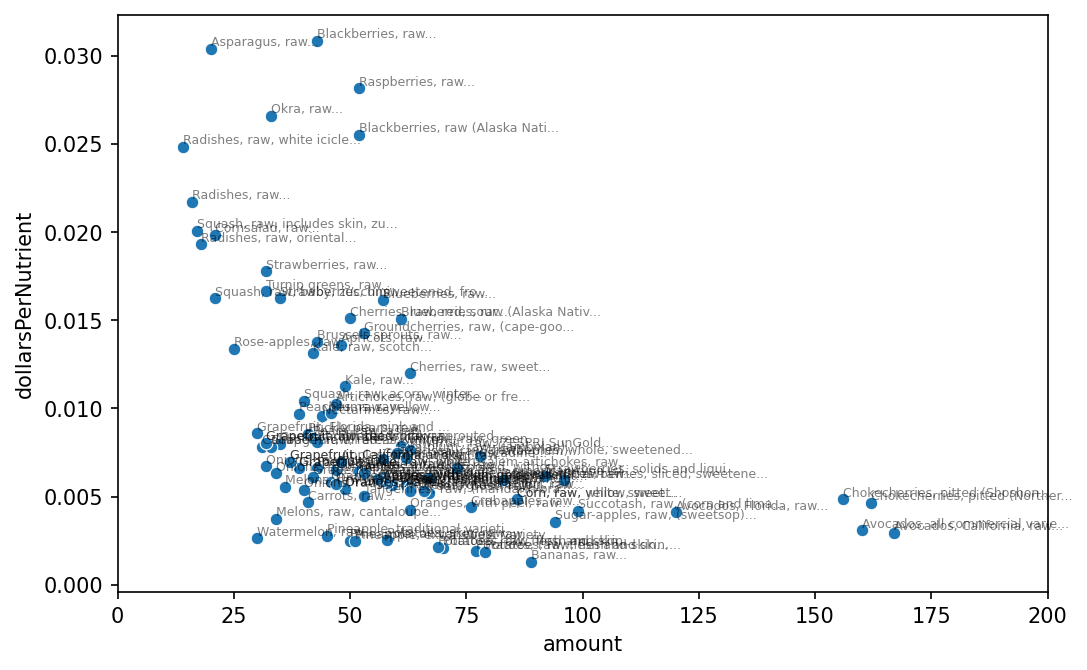

In [149]:
plt.figure(figsize=(8,5),dpi=150)

data=(all[
    (all['variable']=='calories') & 
    (all['name'].str.contains('raw')) & 
    (all['Form']=='Fresh')
    ]
)

sns.scatterplot(data=data
                ,x='amount'
                ,y='dollarsPerNutrient'
               )
x = data.amount
y = data.dollarsPerNutrient
labels = data.name

# Add labels to the markers
for i, label in enumerate(labels):
    if x.iloc[i] > 200:
        pass
    else:
        plt.text(x.iloc[i], y.iloc[i], label[:30]+'...', ha='left', va='bottom', fontsize=6, alpha=0.5)
plt.xlim((0,200));

# Daily Value Requirements

In [50]:
import requests
from bs4 import BeautifulSoup

# URL of the webpage
url = "https://www.fda.gov/food/nutrition-facts-label/daily-value-nutrition-and-supplement-facts-labels"

# Send a GET request to the webpage
response = requests.get(url)

# Parse the HTML content of the webpage using BeautifulSoup
soup = BeautifulSoup(response.content, "html.parser")

# Find the table by its class name
table = soup.find("table", {"class": "table table-bordered"})

# Extract table data and convert it to a DataFrame
table_data = []
for row in table.find_all("tr"):
    row_data = [cell.get_text(strip=True) for cell in row.find_all(["th", "td"])]
    table_data.append(row_data)

dv = pd.DataFrame(table_data[1:], columns=table_data[0])
dv

,Nutrient,Current Daily Value
0,Added sugars,50g
1,Biotin,30mcg
2,Calcium,1300mg
3,Chloride,2300mg
4,Choline,550mg
5,Cholesterol,300mg
6,Chromium,35mcg
7,Copper,0.9mg
8,Dietary Fiber,28g
9,Fat,78g


In [51]:
# add calories

dv.loc[dv.index.size] = ['calories', '2000Kcal']
dv

,Nutrient,Current Daily Value
0,Added sugars,50g
1,Biotin,30mcg
2,Calcium,1300mg
3,Chloride,2300mg
4,Choline,550mg
5,Cholesterol,300mg
6,Chromium,35mcg
7,Copper,0.9mg
8,Dietary Fiber,28g
9,Fat,78g


In [52]:
# split Daily Value from string into numeric amount and unit of measure

pattern = r'(\d+(?:\.\d+)?)\s?(\D+)?'
dv[['DV_amount','DV_UOM']] = dv['Current Daily Value'].str.extract(pattern)
dv['DV_amount'] = pd.to_numeric(dv['DV_amount'],errors='coerce')
dv = dv.drop(labels=['Current Daily Value'], axis=1)
dv['Nutrient'] = dv['Nutrient'].str.lower()
dv

,Nutrient,DV_amount,DV_UOM
0,added sugars,50.0,g
1,biotin,30.0,mcg
2,calcium,1300.0,mg
3,chloride,2300.0,mg
4,choline,550.0,mg
5,cholesterol,300.0,mg
6,chromium,35.0,mcg
7,copper,0.9,mg
8,dietary fiber,28.0,g
9,fat,78.0,g


In [53]:
all['variable'].unique()

array(['serving_size', 'calories', 'total_fat', 'saturated_fat',
       'cholesterol', 'sodium', 'choline', 'folate', 'folic_acid',
       'niacin', 'pantothenic_acid', 'riboflavin', 'thiamin', 'vitamin_a',
       'vitamin_a_rae', 'carotene_alpha', 'carotene_beta',
       'cryptoxanthin_beta', 'lutein_zeaxanthin', 'lucopene',
       'vitamin_b12', 'vitamin_b6', 'vitamin_c', 'vitamin_d', 'vitamin_e',
       'tocopherol_alpha', 'vitamin_k', 'calcium', 'copper', 'irom',
       'magnesium', 'manganese', 'phosphorous', 'potassium', 'selenium',
       'zink', 'protein', 'alanine', 'arginine', 'aspartic_acid',
       'cystine', 'glutamic_acid', 'glycine', 'histidine',
       'hydroxyproline', 'isoleucine', 'leucine', 'lysine', 'methionine',
       'phenylalanine', 'proline', 'serine', 'threonine', 'tryptophan',
       'tyrosine', 'valine', 'carbohydrate', 'fiber', 'sugars',
       'fructose', 'galactose', 'glucose', 'lactose', 'maltose',
       'sucrose', 'fat', 'saturated_fatty_acids',
     

In [54]:
dv['Nutrient'].unique()

array(['added sugars', 'biotin', 'calcium', 'chloride', 'choline',
       'cholesterol', 'chromium', 'copper', 'dietary fiber', 'fat',
       'folate/folic acid', 'iodine', 'iron', 'magnesium', 'manganese',
       'molybdenum', 'niacin', 'pantothenic acid', 'phosphorus',
       'potassium', 'protein', 'riboflavin', 'saturated fat', 'selenium',
       'sodium', 'thiamin', 'total carbohydrate', 'vitamin a',
       'vitamin b6', 'vitamin b12', 'vitamin c', 'vitamin d', 'vitamin e',
       'vitamin k', 'zinc', 'calories'], dtype=object)

In [55]:
matches = fuzzymatch(all['variable'].drop_duplicates(), dv['Nutrient'].drop_duplicates(), 90)
matches

0.0 seconds elapsed


,variable,Nutrient,score
0,calories,calories,100.000000
1,total_fat,fat,90.000000
2,saturated_fat,saturated fat,100.000000
3,cholesterol,cholesterol,100.000000
4,sodium,sodium,100.000000
5,choline,choline,100.000000
6,folate,folate/folic acid,90.000000
7,folic_acid,folate/folic acid,90.000000
8,niacin,niacin,100.000000
9,pantothenic_acid,pantothenic acid,100.000000


In [56]:
all = all.merge(matches.iloc[:,:2], on='variable').merge(dv, on="Nutrient")
all

,name,Item,variable,amount,unit of measure,Form,RetailPrice,PricePer100Grams,dollarsPerNutrient,Nutrient,DV_amount,DV_UOM
0,Cornstarch,Corn,calories,381.00,NaN,Fresh,1.8908,0.416850,0.001094,calories,2000.0,Kcal
1,Cornstarch,Corn,calories,381.00,NaN,Canned,1.0287,0.226790,0.000595,calories,2000.0,Kcal
2,Cornstarch,Corn,calories,381.00,NaN,Frozen,1.6642,0.366893,0.000963,calories,2000.0,Kcal
3,"Snacks, cakes, popcorn",Corn,calories,384.00,NaN,Fresh,1.8908,0.416850,0.001086,calories,2000.0,Kcal
4,"Snacks, cakes, popcorn",Corn,calories,384.00,NaN,Canned,1.0287,0.226790,0.000591,calories,2000.0,Kcal
...,...,...,...,...,...,...,...,...,...,...,...,...
33223,"Corn with red and green peppers, solids and li...",Green peppers,sugars,0.00,NaN,Fresh,1.2772,0.281574,inf,added sugars,50.0,g
33224,"Tomato products, and celery, green peppers, wi...",Green peppers,sugars,7.36,g,Fresh,1.2772,0.281574,0.038257,added sugars,50.0,g
33225,"Restaurant, Arroz con frijoles negros (rice an...",Black beans,sugars,0.86,g,Canned,1.0281,0.226657,0.263555,added sugars,50.0,g
33226,"Restaurant, Arroz con frijoles negros (rice an...",Black beans,sugars,0.86,g,Dried,1.3753,0.303202,0.352560,added sugars,50.0,g


In [57]:
all['PercentOfDV'] = all['amount']/all['DV_amount']
all['CostForEntireDV'] = all['DV_amount']/all['amount'] * all['RetailPrice']
all

,name,Item,variable,amount,unit of measure,Form,RetailPrice,PricePer100Grams,dollarsPerNutrient,Nutrient,DV_amount,DV_UOM,PercentOfDV,CostForEntireDV
0,Cornstarch,Corn,calories,381.00,NaN,Fresh,1.8908,0.416850,0.001094,calories,2000.0,Kcal,0.1905,9.925459
1,Cornstarch,Corn,calories,381.00,NaN,Canned,1.0287,0.226790,0.000595,calories,2000.0,Kcal,0.1905,5.400000
2,Cornstarch,Corn,calories,381.00,NaN,Frozen,1.6642,0.366893,0.000963,calories,2000.0,Kcal,0.1905,8.735958
3,"Snacks, cakes, popcorn",Corn,calories,384.00,NaN,Fresh,1.8908,0.416850,0.001086,calories,2000.0,Kcal,0.1920,9.847917
4,"Snacks, cakes, popcorn",Corn,calories,384.00,NaN,Canned,1.0287,0.226790,0.000591,calories,2000.0,Kcal,0.1920,5.357812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33223,"Corn with red and green peppers, solids and li...",Green peppers,sugars,0.00,NaN,Fresh,1.2772,0.281574,inf,added sugars,50.0,g,0.0000,inf
33224,"Tomato products, and celery, green peppers, wi...",Green peppers,sugars,7.36,g,Fresh,1.2772,0.281574,0.038257,added sugars,50.0,g,0.1472,8.676630
33225,"Restaurant, Arroz con frijoles negros (rice an...",Black beans,sugars,0.86,g,Canned,1.0281,0.226657,0.263555,added sugars,50.0,g,0.0172,59.773256
33226,"Restaurant, Arroz con frijoles negros (rice an...",Black beans,sugars,0.86,g,Dried,1.3753,0.303202,0.352560,added sugars,50.0,g,0.0172,79.959302


In [58]:
all.sort_values(['variable','CostForEntireDV']).head()

,name,Item,variable,amount,unit of measure,Form,RetailPrice,PricePer100Grams,dollarsPerNutrient,Nutrient,DV_amount,DV_UOM,PercentOfDV,CostForEntireDV
23832,"Babyfood, dry, with bananas, mixed, cereal",Bananas,calcium,696.0,mg,Fresh,0.5249,0.115721,0.000166,calcium,1300.0,mg,0.535385,0.980417
23833,"Babyfood, dry, with bananas, rice, cereal",Bananas,calcium,691.0,mg,Fresh,0.5249,0.115721,0.000167,calcium,1300.0,mg,0.531538,0.987511
23830,"Babyfood, dry, with bananas, oatmeal, cereal",Bananas,calcium,651.0,mg,Fresh,0.5249,0.115721,0.000178,calcium,1300.0,mg,0.500769,1.048187
23702,"Babyfood, dry, rice and apples",Apples,calcium,850.0,mg,Fresh,1.5193,0.334948,0.000394,calcium,1300.0,mg,0.653846,2.323635
23408,"Potatoes, unprepared, dry mix, au gratin",Potatoes,calcium,311.0,mg,Fresh,0.6682,0.147313,0.000474,calcium,1300.0,mg,0.239231,2.793119


In [59]:
all['rank_CostForEntireDV'] = all.groupby(['variable', 'Form'])['CostForEntireDV'].rank()
all.sort_values(['variable', 'rank_CostForEntireDV'])[(all['variable']=='calories') & (all['Form']=='Fresh')]

/var/folders/l8/tbybt_pn2j3_tzq2f_xysh340000gp/T/ipykernel_5682/2402948871.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all.sort_values(['variable', 'rank_CostForEntireDV'])[(all['variable']=='calories') & (all['Form']=='Fresh')]


,name,Item,variable,amount,unit of measure,Form,RetailPrice,PricePer100Grams,dollarsPerNutrient,Nutrient,DV_amount,DV_UOM,PercentOfDV,CostForEntireDV,rank_CostForEntireDV
642,"Seeds, dried, watermelon seed kernels",Watermelon,calories,557.0,NaN,Fresh,0.3604,0.079455,0.000143,calories,2000.0,Kcal,0.2785,1.294075,1.0
435,"Snacks, cheese-flavor, made from dried potatoe...",Potatoes,calories,551.0,NaN,Fresh,0.6682,0.147313,0.000267,calories,2000.0,Kcal,0.2755,2.425408,2.0
391,"Snack, plain, made from dried potatoes, potato...",Potatoes,calories,545.0,NaN,Fresh,0.6682,0.147313,0.000270,calories,2000.0,Kcal,0.2725,2.452110,3.0
758,"Babyfood, dry, with bananas, rice, cereal",Bananas,calories,404.0,NaN,Fresh,0.5249,0.115721,0.000286,calories,2000.0,Kcal,0.2020,2.598515,4.0
447,"Snacks, reduced fat, made from dried potatoes,...",Potatoes,calories,502.0,NaN,Fresh,0.6682,0.147313,0.000293,calories,2000.0,Kcal,0.2510,2.662151,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,"Asparagus, without salt, drained, boiled, cook...",Asparagus,calories,18.0,NaN,Fresh,2.7576,0.607947,0.033775,calories,2000.0,Kcal,0.0090,306.400000,383.5
528,"Turnip greens, solids and liquids, canned",Turnip greens,calories,14.0,NaN,Fresh,2.4176,0.532990,0.038071,calories,2000.0,Kcal,0.0070,345.371429,385.0
705,"Asparagus, solids and liquids, no salt added, ...",Asparagus,calories,15.0,NaN,Fresh,2.7576,0.607947,0.040530,calories,2000.0,Kcal,0.0075,367.680000,386.5
708,"Asparagus, solids and liquids, regular pack, c...",Asparagus,calories,15.0,NaN,Fresh,2.7576,0.607947,0.040530,calories,2000.0,Kcal,0.0075,367.680000,386.5


In [60]:
all[all['rank_CostForEntireDV']<=1 & (all['Form']=='Fresh')]

,name,Item,variable,amount,unit of measure,Form,RetailPrice,PricePer100Grams,dollarsPerNutrient,Nutrient,DV_amount,DV_UOM,PercentOfDV,CostForEntireDV,rank_CostForEntireDV
642,"Seeds, dried, watermelon seed kernels",Watermelon,calories,557.000,NaN,Fresh,0.3604,0.079455,0.000143,calories,2000.0,Kcal,0.278500,1.294075,1.0
1565,"Seeds, dried, watermelon seed kernels",Watermelon,total_fat,47.000,g,Fresh,0.3604,0.079455,0.001691,fat,78.0,g,0.602564,0.598111,1.0
2488,"Seeds, dried, watermelon seed kernels",Watermelon,fat,47.370,g,Fresh,0.3604,0.079455,0.001677,fat,78.0,g,0.607308,0.593439,1.0
3411,"Seeds, dried, watermelon seed kernels",Watermelon,saturated_fatty_acids,9.779,g,Fresh,0.3604,0.079455,0.008125,fat,78.0,g,0.125372,2.874650,1.0
4177,"Cake, prepared from recipe, pineapple upside-down",Pineapple,fatty_acids_total_trans,22.000,mg,Fresh,0.5685,0.125333,0.005697,fat,78.0,g,0.282051,2.015591,1.0
5257,"Seeds, dried, watermelon seed kernels",Watermelon,saturated_fat,9.800,g,Fresh,0.3604,0.079455,0.008108,saturated fat,20.0,g,0.490000,0.735510,1.0
5550,"Oil, corn and canola",Corn,monounsaturated_fatty_acids,58.537,g,Fresh,1.8908,0.416850,0.007121,saturated fat,20.0,g,2.926850,0.646019,1.0
7103,"Seeds, dried, watermelon seed kernels",Watermelon,polyunsaturated_fatty_acids,28.094,g,Fresh,0.3604,0.079455,0.002828,saturated fat,20.0,g,1.404700,0.256567,1.0
7869,"Cake, prepared from recipe, pineapple upside-down",Pineapple,cholesterol,22.000,mg,Fresh,0.5685,0.125333,0.005697,cholesterol,300.0,mg,0.073333,7.752273,1.0
8640,"Potatoes, unprepared, dry mix, au gratin",Potatoes,sodium,2095.000,mg,Fresh,0.6682,0.147313,0.000070,sodium,2300.0,mg,0.910870,0.733585,1.0
